# Setup

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time, sys, os, json, itertools
import glob
import gc
from IPython.display import clear_output

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['pdf.use14corefonts'] = True
# plt.rcParams['font.family'] = None
# plt.rcParams['font.sans-serif'] = [None]
# plt.rcParams['font.serif'] = [None]
plt.rcParams["font.size"] = "14"

%load_ext autoreload
%autoreload 2

def clear_mem():
  gc.collect()
  torch.cuda.empty_cache()

In [ ]:
!wget https://www.1001fonts.com/download/font/cmu.serif-roman.ttf
!mv cmu.serif-roman.ttf ../usr/share/fonts/truetype/
import matplotlib.font_manager as fm
path = '/usr/share/fonts/truetype/cmu.serif-roman.ttf'
fontprop = fm.FontProperties(fname=path, size=14)
clear_output()

In [ ]:
!cd /content/
!curl -X POST https://content.dropboxapi.com/2/files/download_zip \
    --header "Authorization: Bearer <>" \
    --header "Dropbox-API-Arg: {\"path\":\"/trials/baseline\"}" \
    --output /content/baseline.zip
!unzip baseline.zip

!curl -X POST https://content.dropboxapi.com/2/files/download_zip \
    --header "Authorization: Bearer <>" \
    --header "Dropbox-API-Arg: {\"path\":\"/trials/kl\"}" \
    --output /content/kl.zip

!unzip kl.zip
clear_output()

In [ ]:
# pytorch calibration function
from scipy.stats import entropy
def calibration(y, p_mean, num_bins=10):
    """Compute the calibration. -- https://github.com/google-research/google-research/blob/master/uncertainties/sources/postprocessing/metrics.py
    References:
    https://arxiv.org/abs/1706.04599
    https://arxiv.org/abs/1807.00263
    Args:
        y: ground truth class label, size (?, 1)
        p_mean: numpy array, size (?, num_classes)
                containing the mean output predicted probabilities
        num_bins: number of bins
    Returns:
        cal: a dictionary
             {reliability_diag: realibility diagram
        ece: Expected Calibration Error
        mce: Maximum Calibration Error
             }
    """
    # Compute for every test sample x, the predicted class.
    class_pred = p_mean.argmax(dim=1)
    # and the confidence (probability) associated with it.
    conf = torch.max(p_mean, dim=1)[0] # should be shape (n_batches)

    # Storage
    acc_tab = torch.zeros(num_bins)  # empirical (true) confidence
    mean_conf = torch.zeros(num_bins)  # predicted confidence
    nb_items_bin = torch.zeros(num_bins)  # number of items in the bins
    tau_tab = torch.linspace(0, 1, num_bins+1)  # confidence bins

    for i in range(num_bins):  # iterate over the bins

        # select the items where the predicted max probability falls in the bin
        sec = (tau_tab[i] < conf) & (conf <= tau_tab[i + 1])
        nb_items_bin[i] = sec.sum()  # Number of items in the bin
        # select the predicted classes, and the true classes
        class_pred_sec, y_sec = class_pred[sec], y[sec]
        # average of the predicted max probabilities
        mean_conf[i] = conf[sec].mean() if nb_items_bin[i] > 0 else float("nan")
        # compute the empirical confidence
        acc_tab[i] = (class_pred_sec == y_sec).sum()/len(y_sec) if nb_items_bin[i] > 0 else float("nan")

    # Cleaning
    mean_conf = mean_conf[nb_items_bin > 0]
    acc_tab = acc_tab[nb_items_bin > 0]
    nb_items_bin = nb_items_bin[nb_items_bin > 0]

    # Reliability diagram
    reliability_diag = (mean_conf, acc_tab)

    weights = nb_items_bin.type(torch.float64) / nb_items_bin.sum()
    if weights.sum() == 0.0:
        print(nb_items_bin.type(torch.float64))
        weights = torch.ones(nb_items_bin.type(torch.float64)) / num_bins

    # Expected Calibration Error
    try:
        ece = ((mean_conf - acc_tab).abs() * weights).sum() / weights.sum()
        # Maximum Calibration Error
        mce = (mean_conf - acc_tab).abs().max()
    except ZeroDivisionError as e:
        # ece = 0.0
        # mce = 0.0
        raise e
    # Saving
    cal = {'reliability_diag': reliability_diag,
           'ece': ece,
           'mce': mce}
    return cal

In [ ]:
!mkdir trials
!mkdir trials100
!unzip /content/baseline/res_int8_base.zip
!unzip /content/baseline/res_fp32_base.zip
!unzip /content/baseline/mbnet_int8_base.zip
!unzip /content/kl/res_int8_c10kl90_b1.zip
!unzip /content/kl/mbnet_int8_c10kl90_b1.zip
!unzip /content/kl/res_int8_c10kl90_b1.zip
# !unzip /content/kl/res_int8_c10kl70_b1.zip
!mv *.npy trials
!unzip /content/baseline/res_int8_c100base.zip
!unzip /content/kl/res_int8_c100kl90_b1.zip
!mv *.npy trials100
# !mv trials/none_1_resnet18_int8_baseline_b1_0.npy trials/baseline.npy
clear_output()

In [ ]:
res_base_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*resnet18_int8_base*.npy"))))
res_fp32_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*resnet18_fp32_base*.npy"))))

res_kl90_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*resnet18_int8_c10kl90_b1*.npy"))))
res_kl70_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*resnet18_int8_c10kl70_b1*.npy"))))

mbn_base_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*mbnet_int8_base*.npy"))))
mbn_kl90_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*mbnet_int8_c10kl90*.npy"))))

res_c100base_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials100/*resnet18_int8_base*.npy"))))
res_c100kl90_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials100/*resnet18_int8_c100kl90*.npy"))))

In [ ]:
xlabels = []
major_labels = []
idx = 0
for bf in res_base_files:
  if idx % 5 == 0:
    string = bf.split("/")[3].split("_resnet18")[0]
    if "1" in string or "none" in string:
      major_labels.append(string[:-2].replace("_", " "))
    xlabels.append(string[-1])
  idx += 1

In [ ]:
def fix_trials(arr):
  return [np.mean(arr[i:i+5]) for i in range(0, len(arr), 5)], [np.std(arr[i:i+5]) for i in range(0, len(arr), 5)]

def get_pm_str(arr, i):
  (arr_mean, arr_std) = arr
  arr_mean = [arr_mean[j+(i-1)] for j in range(0, len(arr_mean), 5)]
  arr_std = [arr_std[j+(i-1)] for j in range(0, len(arr_std), 5)]
  return f"{np.mean(np.array(arr_mean)).round(4)} $\pm$ {np.sqrt(np.mean([s**2 for s in arr_std])).round(4)}"


def get_pm(arr, i):
  (arr_mean, arr_std) = arr
  arr_mean = [arr_mean[j+(i-1)] for j in range(0, len(arr_mean), 5)]
  arr_std = [arr_std[j+(i-1)] for j in range(0, len(arr_std), 5)]
  return np.mean(np.array(arr_mean)).round(4), np.sqrt(np.mean([s**2 for s in arr_std])).round(4)

# Section 4.1
Table 4.1 (Baseline)

Figure 4.1 (accuracy vs entropy, baseline)

Text(0.5, 0, 'Corruption Type')

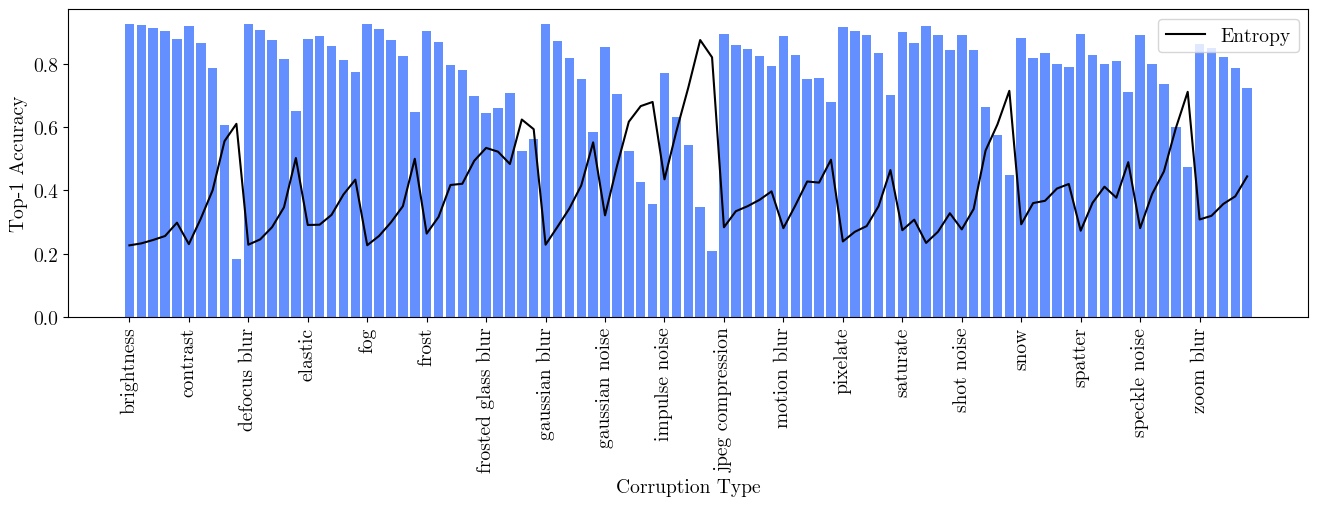

In [ ]:
# plot resnet18 fp32 vs int8 no adaptation
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
plt.figure(figsize=(16, 4))
for j, flg in enumerate([res_base_files]):
  base_accs = []
  base_ents = []
  for bfl in flg:
    res = np.load(bfl, allow_pickle=True)[()]
    base_accs.append(res["acc"])
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    base_ents.append(np.mean(entropy(smax, axis=1)))

  trial_accs, trial_a_stds = fix_trials(base_accs)
  trial_ents, trial_e_stds = fix_trials(base_ents)
  trial_ents = np.array(trial_ents)
  trial_e_stds = np.array(trial_e_stds)
  plt.bar(range(len(xlabels)), trial_accs, color=colors[j*4])
  plt.errorbar(range(len(xlabels)), trial_accs, yerr=trial_a_stds, color="black", elinewidth=0.5, fmt="none")
  plt.plot(trial_ents, color="black", label="Entropy")
  # plt.fill_between(trial_ents+trial_e_stds, trial_ents-trial_e_stds, color=colors[-1], alpha=0.3)

plt.xticks(range(0, len(xlabels), 5), labels=major_labels, rotation=90, fontproperties=fontprop, minor=False)
# plt.xticks(range(len(xlabels)), labels=xlabels, fontproperties=fontprop, minor=True)
plt.yticks(fontproperties=fontprop)
# plt.grid(color='gray', linestyle='dashed', which="major")
plt.legend(prop=fontprop)
plt.ylabel("Top-1 Accuracy", fontproperties=fontprop)
plt.xlabel("Corruption Type", fontproperties=fontprop)

# Appendix

Text(0.5, 0, 'Corruption Type')

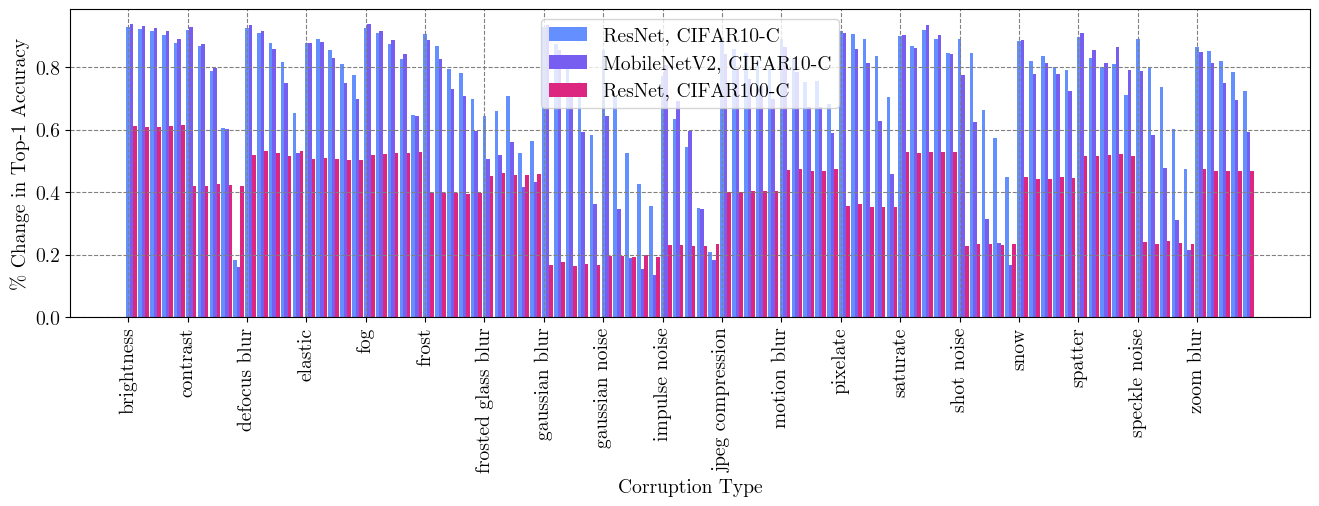

In [ ]:
# plot baseline just to see
plot_labels = ["ResNet, CIFAR10-C", "MobileNetV2, CIFAR10-C", "ResNet, CIFAR100-C"]
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
plt.figure(figsize=(16, 4))
for j, flg in enumerate([res_base_files, mbn_base_files, res_c100base_files]):
  base_accs = []
  for bfl in flg:
    res = np.load(bfl, allow_pickle=True)[()]
    base_accs.append(res["acc"])

  trial_accs, trial_stds = fix_trials(base_accs)
  plt.bar([i+j*0.3 for i in range(len(xlabels))], trial_accs, label=plot_labels[j], color=colors[j%len(colors)], width=0.3)

plt.xticks(range(0, len(xlabels), 5), labels=major_labels, rotation=90, fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")
# plt.legend(prop=fontprop)
plt.ylabel("% Change in Top-1 Accuracy", fontproperties=fontprop)
plt.xlabel("Corruption Type", fontproperties=fontprop)

Text(0.5, 0, 'Corruption Type')

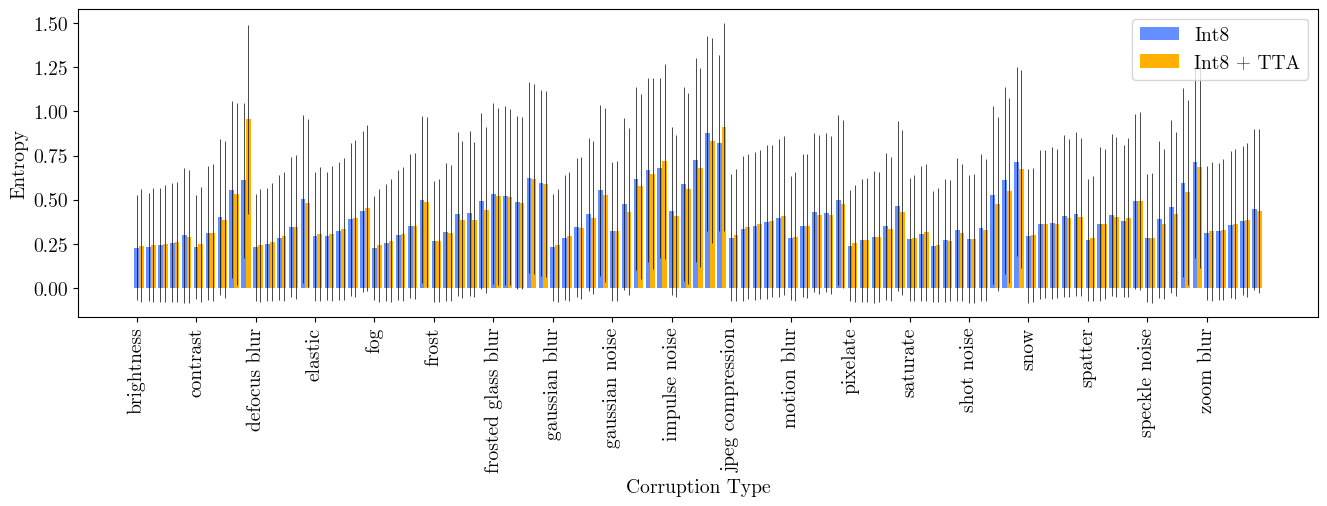

In [ ]:
# plot resnet18 int8 vs adapted int8
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
labels = ["Int8", "Int8 + TTA"]
plt.figure(figsize=(16, 4))
for j, flg in enumerate([res_base_files, res_kl90_files]):
  base_accs = []
  base_ents = []
  for bfl in flg:
    res = np.load(bfl, allow_pickle=True)[()]
    base_accs.append(res["acc"])
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    base_ents.append(entropy(smax, axis=1))
    # base_stds

  # trial_accs, trial_a_stds = fix_trials(base_accs)
  trial_ents, trial_e_stds = fix_trials(base_ents)
  trial_ents = np.array(trial_ents)
  trial_e_stds = np.array(trial_e_stds)

  plt.bar([i+0.4*j for i in range(len(xlabels))], trial_ents, color=colors[(j*4)%5], width=0.4, label=labels[j])
  plt.errorbar([i+0.4*j for i in range(len(xlabels))], trial_ents, yerr=trial_e_stds, color="black", elinewidth=0.5, fmt="none")
  # plt.bar([i+0.4 for i in range(len(xlabels))], trial_accs, color=colors[-1], width=0.4)
  # plt.errorbar(range(len(xlabels)), trial_accs, yerr=trial_a_stds, color="black", elinewidth=0.5, fmt="none")
  # plt.plot(trial_ents, color="black", label="Entropy")
  # plt.fill_between(trial_ents+trial_e_stds, trial_ents-trial_e_stds, color=colors[-1], alpha=0.3)

plt.xticks(range(0, len(xlabels), 5), labels=major_labels, rotation=90, fontproperties=fontprop, minor=False)
# plt.xticks(range(len(xlabels)), labels=xlabels, fontproperties=fontprop, minor=True)
plt.yticks(fontproperties=fontprop)
# plt.grid(color='gray', linestyle='dashed', which="major")
plt.legend(prop=fontprop)
plt.ylabel("Entropy", fontproperties=fontprop)
plt.xlabel("Corruption Type", fontproperties=fontprop)

In [ ]:
def scale_to_mean_std(numbers):
    mean = np.mean(numbers)
    std = math.sqrt(sum((x - mean) ** 2 for x in numbers) / len(numbers))
    scaled_numbers = [(x - mean) / std for x in numbers]
    # print(mean, std)

    # scaled_numbers = (np.array(numbers) - np.median(numbers)) / (np.quantile(numbers, 0.75) - np.quantile(numbers, 0.25))
    return scaled_numbers

In [ ]:
# plot KL divergence: for each severity, average across corruption types per-severity
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
# labels = ["Int8", "Int8 + TTA"]

plt.figure(figsize=(8, 8))
for j, flg in enumerate([res_kl90_files]):
  kls = []
  for bfl in flg:
    res = np.load(bfl, allow_pickle=True)[()]
    kls.append(res["kl"])

#   # trial_accs, trial_a_stds = fix_trials(base_accs)
#   trial_ents, trial_e_stds = fix_trials(base_ents)
#   trial_ents = np.array(trial_ents)
#   trial_e_stds = np.array(trial_e_stds)

#   plt.bar([i+0.4*j for i in range(len(xlabels))], trial_ents, color=colors[(j*4)%5], width=0.4, label=labels[j])
#   plt.errorbar([i+0.4*j for i in range(len(xlabels))], trial_ents, yerr=trial_e_stds, color="black", elinewidth=0.5, fmt="none")
#   # plt.bar([i+0.4 for i in range(len(xlabels))], trial_accs, color=colors[-1], width=0.4)
#   # plt.errorbar(range(len(xlabels)), trial_accs, yerr=trial_a_stds, color="black", elinewidth=0.5, fmt="none")
#   # plt.plot(trial_ents, color="black", label="Entropy")
#   # plt.fill_between(trial_ents+trial_e_stds, trial_ents-trial_e_stds, color=colors[-1], alpha=0.3)

# plt.xticks(range(0, len(xlabels), 5), labels=major_labels, rotation=90, fontproperties=fontprop, minor=False)
# # plt.xticks(range(len(xlabels)), labels=xlabels, fontproperties=fontprop, minor=True)
# plt.yticks(fontproperties=fontprop)
# # plt.grid(color='gray', linestyle='dashed', which="major")
# plt.legend(prop=fontprop)
# plt.ylabel("Entropy", fontproperties=fontprop)
# plt.xlabel("Corruption Type", fontproperties=fontprop)

<Figure size 800x800 with 0 Axes>

In [ ]:
averaged_by_trial = [np.mean(kls[i:i+5], axis=0) for i in range(0, 475, 5)]
stdev_by_trial = [np.std(kls[i:i+5], axis=0) for i in range(0, 475, 5)]

averaged_by_severity = [np.mean([averaged_by_trial[i+j] for i in range(0, 95, 5)], axis=0) for j in range(5)]
stdev_by_severity = [np.sqrt(np.mean([stdev_by_trial[i+j]**2 for i in range(0, 95, 5)], axis=0)) for j in range(5)]

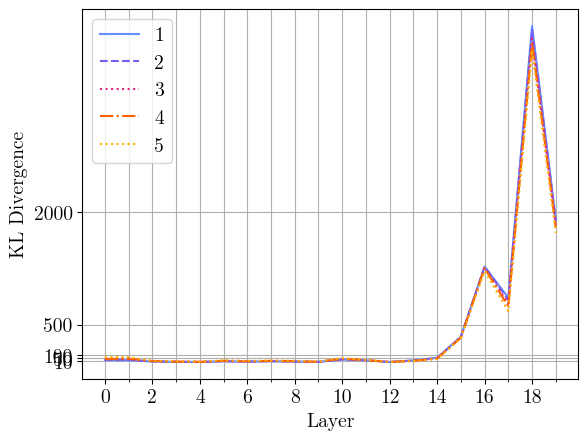

In [ ]:
import math
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
line_types = ["solid", "dashed", "dotted", "dashdot", ":"]
for i, a in enumerate(averaged_by_severity):
  # a_norm = scale_to_mean_std(a)
  # a_truncd = [(max(min(div, 1), -1) + 1)/2 for div in a_norm]
  s = stdev_by_severity[i]
  plt.plot((a), label=i+1, color=colors[i], linestyle=line_types[i], zorder=10+i)
  plt.fill_between(range(20), (a)-(s), (a)+(s), color=colors[i], alpha=0.25, zorder=10-i)
plt.xticks(range(0, 20, 2), labels=range(0, 20, 2), fontproperties=fontprop)
plt.xticks(range(0, 20), fontproperties=fontprop, minor=True)
plt.yticks(([10, 50, 100, 500, 2000]), labels=[10, 50, 100, 500, 2000], fontproperties=fontprop)
plt.xlabel("Layer", fontproperties=fontprop)
plt.ylabel("KL Divergence", fontproperties=fontprop)
plt.legend(prop=fontprop, loc="upper left")
plt.grid(which="both")

# Section 4.4
Figure 4.5 (entropy, calibration error, confidence)

0.0012121301513162788 0.005776662054811836
0.0028575013873671966 0.012796774585425058
0.0049254506358486164 0.022063066365101573
0.007175618366580863 0.0342534530460735
0.014802059346706337 0.04964996891843086
0.0009103849530220032 0.004313194751739502
0.002147441729903221 0.00956365093588829
0.003696479368954897 0.016530786454677582
0.005467462632805109 0.02574525624513626
0.011189806 0.037199453
0.0020077397094815674 0.007792096697421659
0.005602701780817056 0.016296136601557522
0.011717051126294033 0.02668172540651508
0.019747470745336244 0.04278339331285384
0.03214344462258971 0.06453920244878372
0.003664346637797776 0.008331688706173701
0.007945477653124273 0.017862480131426425
0.01341345754637543 0.028937105771551463
0.020391049593286952 0.04080651926373284
0.029313968122107115 0.0568245010651955
0.002745412848889828 0.006337403506040573
0.006019745208323002 0.013562259078025819
0.010297220386564731 0.021867261826992036
0.01592844072729349 0.03078199103474617
0.023155447 0.042939

<ipython-input-81-9c442e14e13e>:86: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)


<Figure size 2000x1600 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


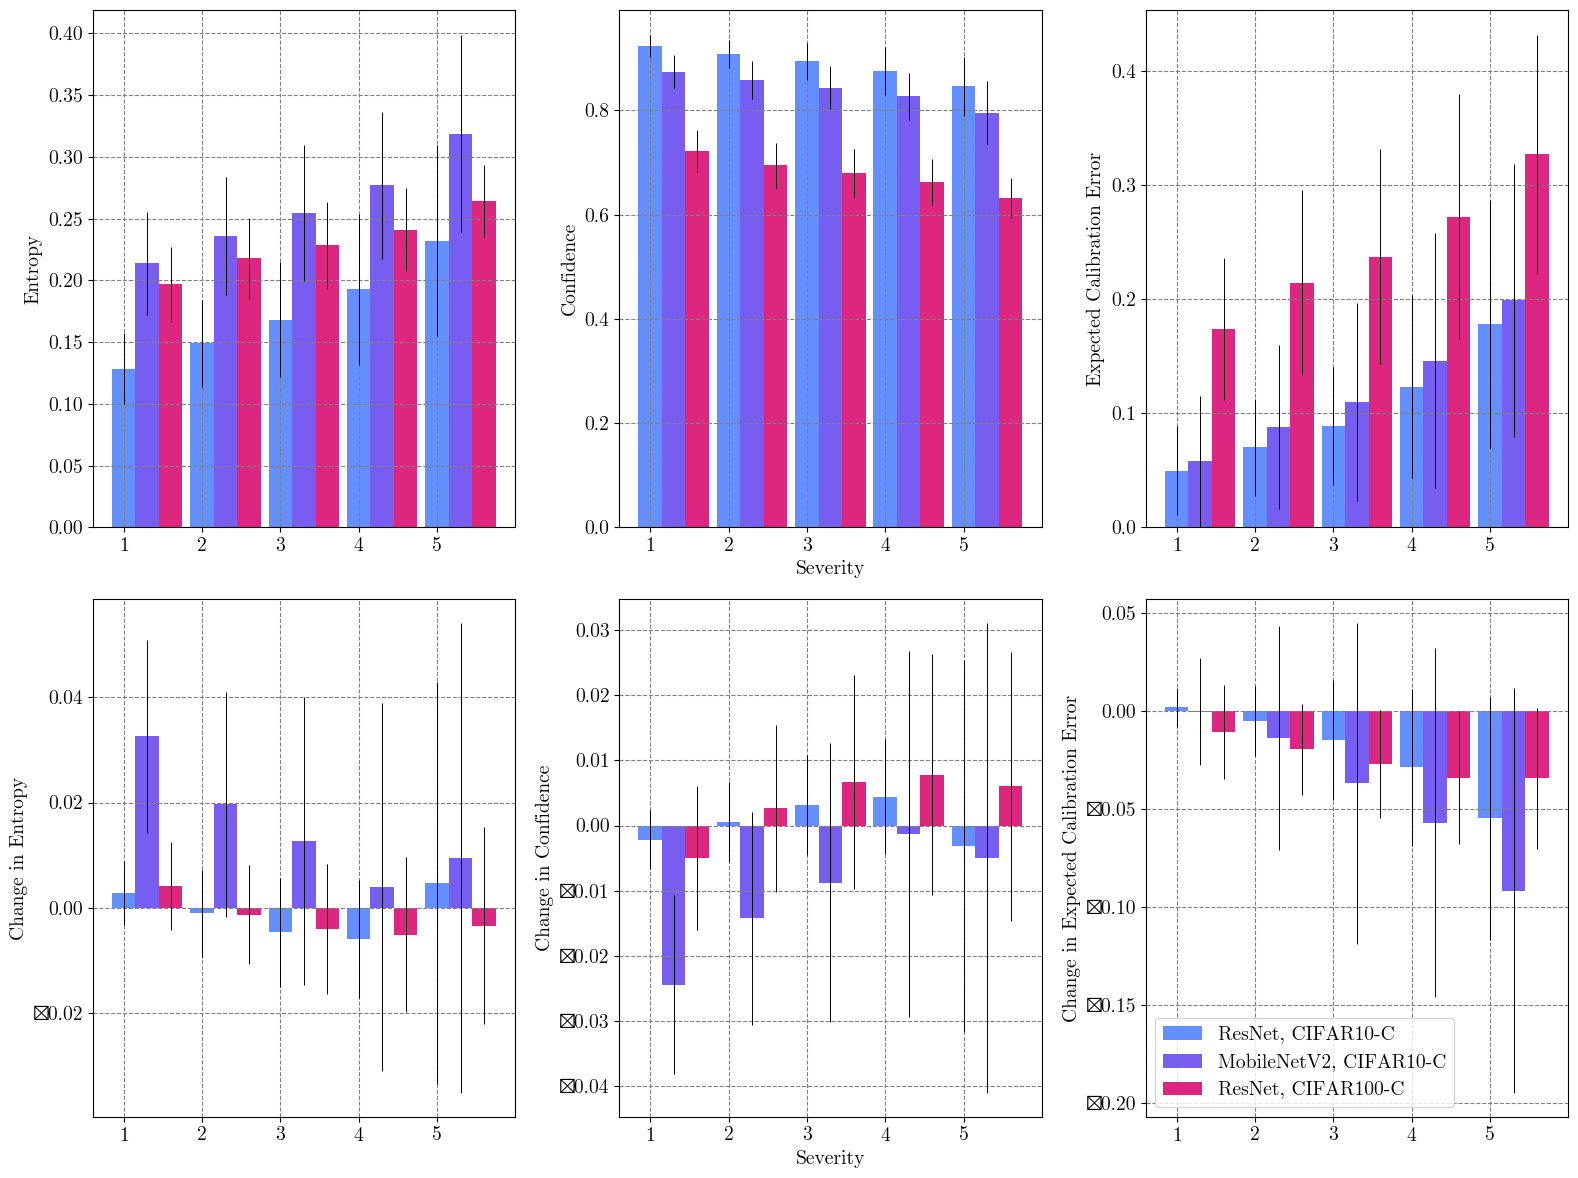

In [ ]:
# all_df = pd.DataFrame(columns=["Model", "Dataset", "Severity", "B", "TTA", "$\% \Delta Acc.$"])
uncal_df = pd.DataFrame(columns=["Model", "Dataset", "Severity", "Entropy", "Confidence", "ECE"])
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
plot_labels = ["ResNet, CIFAR10-C", "MobileNetV2, CIFAR10-C", "ResNet, CIFAR100-C"]
plt.figure(figsize=(20, 16))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 12))
df_count = 0
axes = [ax1, ax2, ax3, ax4, ax5, ax6]

for j, (base_flg, flg) in enumerate([(res_base_files, res_kl90_files), (mbn_base_files, mbn_kl90_files), (res_c100base_files, res_c100kl90_files)]):
  base_ents = []
  ents = []
  base_confs = []
  confs = []
  base_cals = []
  cals = []

  entscale = 10
  if "100" in plot_labels[j]:
    entscale = 100

  for bfl, fl in zip(base_flg, flg):

    res = np.load(fl, allow_pickle=True)[()]
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    ents.append(np.mean(entropy(smax, axis=1))/np.log(entscale))
    confs.append(torch.max(smax, axis=1)[0].mean())
    cals.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1))["ece"])

    res = np.load(bfl, allow_pickle=True)[()]
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    base_ents.append(np.mean(entropy(smax, axis=1))/np.log(entscale))
    base_confs.append(torch.max(smax, axis=1)[0].mean())
    base_cals.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1))["ece"])


  for axnum, (arr, base_arr) in enumerate([(ents, base_ents), (confs, base_confs), (cals, base_cals)]):
    # trial_ents, trial_stds = fix_trials(arr)
    # trial_b_ents, trial_b_stds = fix_trials(base_arr)
    avg_ents = [0]*5
    std_ents = [0]*5
    avg_ents_del = [0]*5
    std_ents_del = [0]*5

    for sev_num in range(5):
      take_arr = []
      for corr_num in range(0, len(arr), 25):
        for i in range(5):
          take_arr.append(corr_num+i+5*sev_num)
      temp = np.array(arr)[take_arr]
      base_temp = np.array(base_arr)[take_arr]

      avg_ents[sev_num] = np.mean(temp)
      std_ents[sev_num] = np.std(temp)
      avg_ents_del[sev_num] = np.mean(temp-base_temp)
      std_ents_del[sev_num] = np.std(temp-base_temp)
      print(np.mean(std_ents_del), np.mean(std_ents))

    axes[axnum].bar([i+j*0.3 for i in range(5)], avg_ents, label=plot_labels[j], color=colors[j%len(colors)], width=0.3)
    axes[axnum].errorbar([i+j*0.3 for i in range(5)], avg_ents, yerr=std_ents, color="black", fmt="none", elinewidth=0.7)
    axes[axnum+3].bar([i+j*0.3 for i in range(5)], avg_ents_del, label=plot_labels[j], color=colors[j%len(colors)], width=0.3)
    axes[axnum+3].errorbar([i+j*0.3 for i in range(5)], avg_ents_del, yerr=std_ents_del, color="black", fmt="none", elinewidth=0.7)


# short_labels = [res["dset_names"][i][:-2].replace("_", " ") for i in range(0, len(res["dset_names"]), 9)]
for ax_num, ax in enumerate(axes):
  ax.set_xticks(range(5), labels=[1,2,3,4,5], fontproperties=fontprop)
  ax.grid(color='gray', linestyle='dashed', which="major")
  # ax1.legend(prop=fontprop)
  if ax_num >= 3:
    prefix = "Change in "
  else:
    prefix = ""
  if ax_num %3 == 0:
    ax.set_ylabel(f"{prefix}Entropy", fontproperties=fontprop)
  elif ax_num %3 == 1:
    ax.set_ylabel(f"{prefix}Confidence", fontproperties=fontprop)
    ax.set_xlabel("Severity", fontproperties=fontprop)
  elif ax_num %3 == 2:
    ax.set_ylabel(f"{prefix}Expected Calibration Error", fontproperties=fontprop)
  for label in ax.get_xticklabels():
      label.set_fontproperties(fontprop)
  for label in ax.get_yticklabels():
      label.set_fontproperties(fontprop)
ax.legend(prop=fontprop, loc="lower left")
fig.tight_layout()

<Figure size 640x480 with 0 Axes>

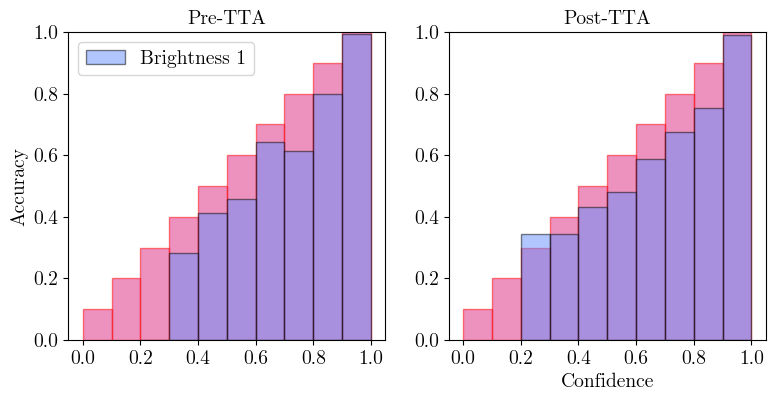

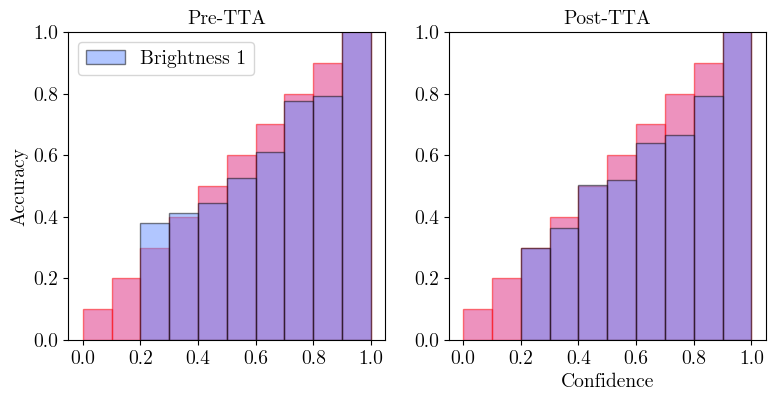

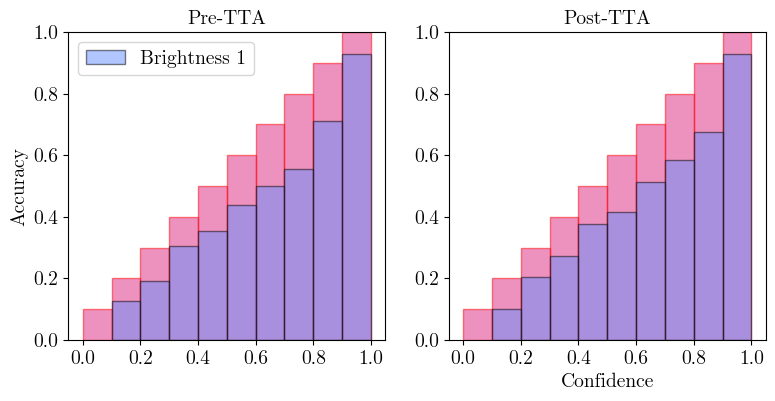

In [ ]:
# Reliability Diagram for brightness
uncal_df = pd.DataFrame(columns=["Model", "Dataset", "Severity", "Entropy", "Confidence", "ECE"])
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
plot_labels = ["ResNet, CIFAR10-C", "MobileNetV2, CIFAR10-C", "ResNet, CIFAR100-C"]
df_count = 0

plt.tight_layout()
for j, (base_flg, flg) in enumerate([(res_base_files, res_kl90_files), (mbn_base_files, mbn_kl90_files), (res_c100base_files, res_c100kl90_files)]):
  base_cals = []
  cals = []

  entscale = 10
  if "100" in plot_labels[j]:
    entscale = 100

  for bfl, fl in zip(base_flg, flg):
    if "brightness_1" not in bfl:
      continue

    res = np.load(fl, allow_pickle=True)[()]
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    cals.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1)))

    res = np.load(bfl, allow_pickle=True)[()]
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    base_cals.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1)))

  for bc, c in zip(base_cals, cals):
    conf_8 = np.mean([c["reliability_diag"][0] for c in base_cals], axis=0)
    conf_32 = np.mean([c["reliability_diag"][0] for c in cals], axis=0)
    acc_8 = np.mean([c["reliability_diag"][1] for c in base_cals], axis=0)
    acc_32 = np.mean([c["reliability_diag"][1] for c in cals], axis=0)

  # i'm workin heeyah
  i = 0
  fprange = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.])
  if True:
    # ent = entropy(torch.softmax(torch.concatenate([r.detach() for r in [r.detach() for r in results["outputs"]]]), dim=0))
    plt.figure(figsize=(9, 4))
    plt.subplot(1, 2, 1,)
    # plt.grid(color='gray', linestyle='dashed', which="major")

    plt.bar(fprange-0.1, fprange, alpha=0.5, width=0.1, edgecolor="red", color=colors[2], align="edge")
    plt.bar(fprange-0.1, (acc_8/conf_8)*fprange, alpha=0.5, width=0.1, color=colors[0], edgecolor="black", align="edge", label="Brightness 1")
    plt.ylim(0, 1)
    plt.ylabel("Accuracy", fontproperties=fontprop)
    plt.title("Pre-TTA", fontproperties=fontprop)
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontproperties=fontprop, labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.yticks(fontproperties=fontprop)
    plt.legend(prop=fontprop)

  if True:
    plt.subplot(1, 2, 2)
    # plt.grid(color='gray', linestyle='dashed', which="major")

    plt.bar(fprange-0.1, fprange, alpha=0.5, width=0.1, edgecolor="red", color=colors[2], align="edge")
    plt.bar(fprange-0.1, (acc_32/conf_32)*fprange, alpha=0.5, width=0.1, color = colors[0], edgecolor="black", align="edge")
    # plt.title(labels[i])
    plt.xlabel("Confidence", fontproperties=fontprop)
    plt.title("Post-TTA", fontproperties=fontprop)
    plt.yticks(fontproperties=fontprop)
    plt.xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontproperties=fontprop, labels=[0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    plt.ylim(0, 1)
    plt.pause(0.1)
    # plt.cla()
  i += 1

In [ ]:
# how does confidence change?
uncal_df = pd.DataFrame(columns=["Model", "Dataset", "Severity", "Entropy", "Confidence", "ECE"])
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
plot_labels = ["ResNet, CIFAR10-C", "MobileNetV2, CIFAR10-C", "ResNet, CIFAR100-C"]
df_count = 0

for j, (base_flg, flg) in enumerate([(res_base_files, res_kl90_files)]):
  base_confs = []
  confs = []
  orig_right, new_right = [], []
  orig_conf, new_conf = [], []

  entscale = 10
  if "100" in plot_labels[j]:
    entscale = 100

  for bfl, fl in zip(base_flg, flg):
    if "brightness_1" not in bfl:
      continue

    res = np.load(fl, allow_pickle=True)[()]
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    confs.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1)))

    res = np.load(bfl, allow_pickle=True)[()]
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    base_confs.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1)))



# Section 4.3
Figure 4.3 (confidence/entropy versus accuracy % change)

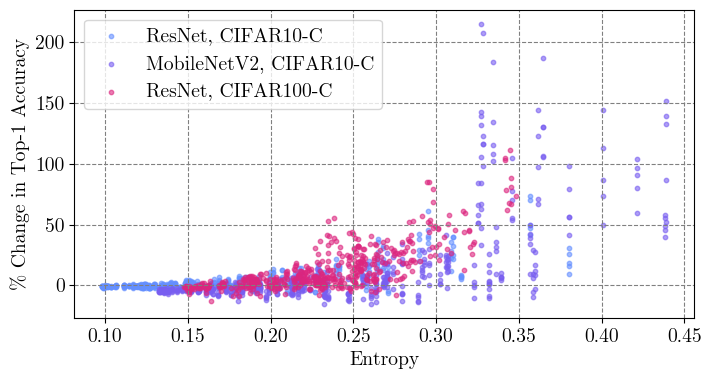

,Model,Dataset,Severity,B,TTA,$\% \Delta Acc.$
0,,,1,0.879 $\pm$ 0.0,0.875 $\pm$ 0.0466,-0.38
1,,,2,0.8333 $\pm$ 0.0,0.839 $\pm$ 0.0563,0.89
2,ResNet,CIFAR10-C 3,3,0.7875 $\pm$ 0.0,0.8057 $\pm$ 0.0725,2.96
3,,,4,0.7195 $\pm$ 0.0,0.7526 $\pm$ 0.0856,6.24
4,,,5,0.6166 $\pm$ 0.0,0.6683 $\pm$ 0.1034,12.92


In [ ]:
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
plot_labels = ["ResNet, CIFAR10-C", "MobileNetV2, CIFAR10-C", "ResNet, CIFAR100-C"]
plt.figure(figsize=(8, 4))
df_count = 0
for j, (base_flg, flg) in enumerate([(res_base_files, res_kl90_files), (mbn_base_files, mbn_kl90_files), (res_c100base_files, res_c100kl90_files)]):
  base_accs = []
  accs = []
  base_ents = []
  for bfl, fl in zip(base_flg, flg):
    res = np.load(fl, allow_pickle=True)[()]
    accs.append(res["acc"])
    res = np.load(bfl, allow_pickle=True)[()]
    base_accs.append(res["acc"])
    smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
    if "100" in plot_labels[j]:
      base_ents.append(np.mean(entropy(smax, axis=1))/np.log(100))
    elif "10-" in plot_labels[j]:
      base_ents.append(np.mean(entropy(smax, axis=1))/np.log(10))
  plt.scatter(base_ents, 100*(np.array(accs)-np.array(base_accs))/np.array(base_accs), label=plot_labels[j], color = colors[j%len(colors)], s=10, alpha=0.6)
  # trial_accs, trial_stds = fix_trials(accs)
  # trial_baccs, trial_bstds = fix_trials(base_accs)
  # plt.bar([i+j*0.3 for i in range(len(xlabels))], (np.array(trial_accs) - np.array(trial_baccs))/np.array(trial_baccs), label=plot_labels[j], color=colors[j%len(colors)], width=0.3)
  # plt.errorbar([i+j*0.3 for i in range(len(xlabels))], (np.array(trial_accs) - np.array(trial_baccs))/np.array(trial_baccs), yerr=trial_stds, color="black", fmt="none", elinewidth=0.7)
  # arr_mean = (100.*((np.array(trial_accs) - np.array(trial_baccs))/np.array(trial_baccs)))
  # for k in range(1, 6):
  #   if k == 3:
  #     l1 = plot_labels[j].split(", ")[0]
  #     l2 = f"{plot_labels[j].split(', ')[1]} {k}"
  #   else:
  #     l1, l2 = "", ""
  #   df_count += 1

# short_labels = [res["dset_names"][i][:-2].replace("_", " ") for i in range(0, len(res["dset_names"]), 9)]
plt.xticks(fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")
plt.legend(prop=fontprop)
plt.ylabel("% Change in Top-1 Accuracy", fontproperties=fontprop)
plt.xlabel("Entropy", fontproperties=fontprop)

plt.show()
all_df.head()

# Table 4.4: batch size effects

In [ ]:
!unzip /content/kl/res_int8_c10kl90_b4.zip
!mv *.npy trials
clear_output()

In [ ]:
res_base_files
res_kl90_files
res_kl90_4_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*resnet18_int8_c10kl90_b4*.npy"))))

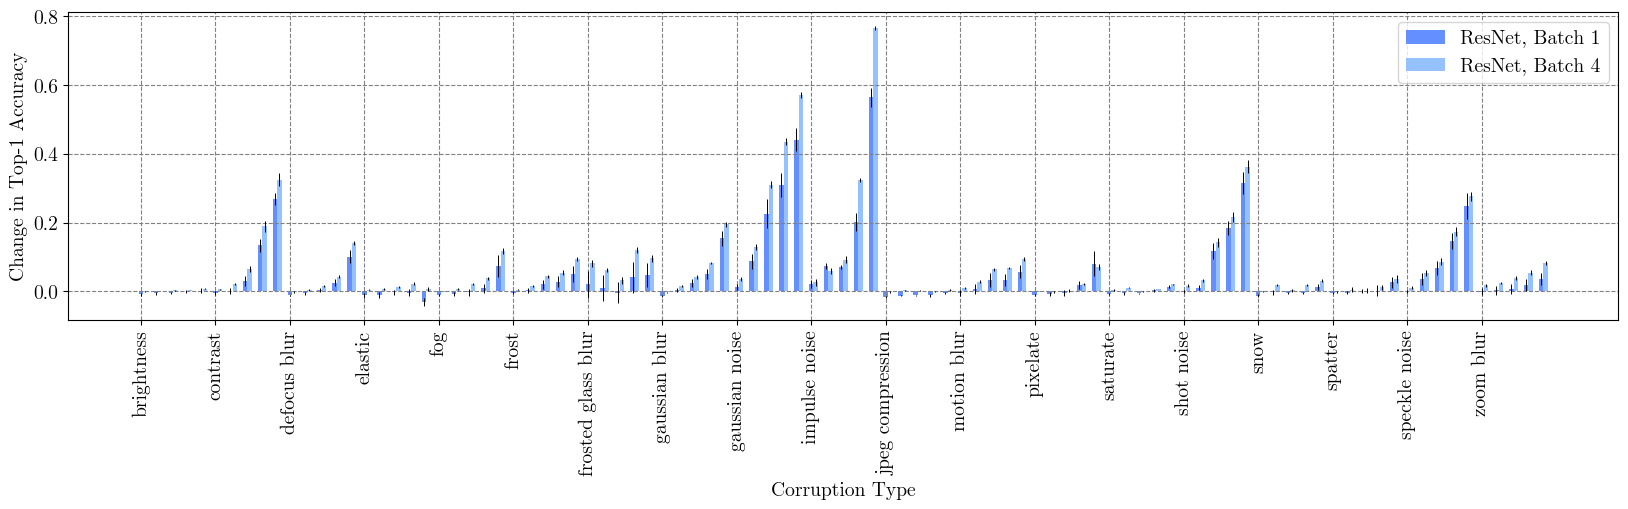

,Model,Batch Size,Severity,B,TTA,$\% \Delta Acc.$
0,,,1,0.879 $\pm$ 0.0,0.875 $\pm$ 0.0107,-0.38
1,,,2,0.8333 $\pm$ 0.0,0.839 $\pm$ 0.0129,0.89
2,ResNet,Batch 1 3,3,0.7875 $\pm$ 0.0,0.8057 $\pm$ 0.0166,2.96
3,,,4,0.7195 $\pm$ 0.0,0.7526 $\pm$ 0.0196,6.24
4,,,5,0.6166 $\pm$ 0.0,0.6683 $\pm$ 0.0237,12.92


In [ ]:
all_df = pd.DataFrame(columns=["Model", "Batch Size", "Severity", "B", "TTA", "$\% \Delta Acc.$"])
colors = ["#648fff", "#96C1FF", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]
plot_labels = ["ResNet, Batch 1", "ResNet, Batch 4"]
plt.figure(figsize=(20, 4))
df_count = 0
for j, (base_flg, flg) in enumerate([(res_base_files, res_kl90_files), (res_base_files, res_kl90_4_files)]):
  base_accs = []
  accs = []
  for bfl, fl in zip(base_flg, flg):
    res = np.load(fl, allow_pickle=True)[()]
    accs.append(res["acc"])
    res = np.load(bfl, allow_pickle=True)[()]
    base_accs.append(res["acc"])
  trial_accs, trial_stds = fix_trials(accs)
  trial_baccs, trial_bstds = fix_trials(base_accs)
  plt.bar([i+j*0.3 for i in range(len(xlabels))], (np.array(trial_accs) - np.array(trial_baccs))/np.array(trial_baccs), label=plot_labels[j], color=colors[j%len(colors)], width=0.3)
  plt.errorbar([i+j*0.3 for i in range(len(xlabels))], (np.array(trial_accs) - np.array(trial_baccs))/np.array(trial_baccs), yerr=trial_stds, color="black", fmt="none", elinewidth=0.7)
  arr_mean = (100.*((np.array(trial_accs) - np.array(trial_baccs))/np.array(trial_baccs)))
  for k in range(1, 6):
    if k == 3:
      l1 = plot_labels[j].split(", ")[0]
      l2 = f"{plot_labels[j].split(', ')[1]} {k}"
    else:
      l1, l2 = "", ""

    all_df.loc[df_count] = [
      l1,
      l2,
      k,
      get_pm_str((trial_baccs, trial_bstds), k),
      get_pm_str((trial_accs, trial_stds), k),
      np.mean([arr_mean[i+(k-1)] for i in range(0, len(arr_mean), 5)]).round(2)
    ]
    df_count += 1

# short_labels = [res["dset_names"][i][:-2].replace("_", " ") for i in range(0, len(res["dset_names"]), 9)]
plt.xticks(range(0, len(xlabels), 5), labels=major_labels, rotation=90, fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")
plt.legend(prop=fontprop)
plt.ylabel("Change in Top-1 Accuracy", fontproperties=fontprop)
plt.xlabel("Corruption Type", fontproperties=fontprop)

# ax2.xticks(range(0, len(xlabels), 5), labels=major_labels, rotation=90, fontproperties=fontprop)
# ax2.yticks(fontproperties=fontprop)
# ax2.grid(color='gray', linestyle='dashed', which="major")
# ax2.legend(prop=fontprop)
# ax2.ylabel("Change in Top-1 Accuracy", fontproperties=fontprop)
# ax2.xlabel("Corruption Type", fontproperties=fontprop)
plt.show()
all_df.head()

In [ ]:
all_df.to_latex()

'\\begin{tabular}{lllrllr}\n\\toprule\n & Model & Batch Size & Severity & B & TTA & $\\% \\Delta Acc.$ \\\\\n\\midrule\n0 &  &  & 1 & 0.879 $\\pm$ 0.0 & 0.875 $\\pm$ 0.0107 & -0.380000 \\\\\n1 &  &  & 2 & 0.8333 $\\pm$ 0.0 & 0.839 $\\pm$ 0.0129 & 0.890000 \\\\\n2 & ResNet & Batch 1 3 & 3 & 0.7875 $\\pm$ 0.0 & 0.8057 $\\pm$ 0.0166 & 2.960000 \\\\\n3 &  &  & 4 & 0.7195 $\\pm$ 0.0 & 0.7526 $\\pm$ 0.0196 & 6.240000 \\\\\n4 &  &  & 5 & 0.6166 $\\pm$ 0.0 & 0.6683 $\\pm$ 0.0237 & 12.920000 \\\\\n5 &  &  & 1 & 0.879 $\\pm$ 0.0 & 0.887 $\\pm$ 0.0041 & 1.050000 \\\\\n6 &  &  & 2 & 0.8333 $\\pm$ 0.0 & 0.8528 $\\pm$ 0.0049 & 2.580000 \\\\\n7 & ResNet & Batch 4 3 & 3 & 0.7875 $\\pm$ 0.0 & 0.8215 $\\pm$ 0.0067 & 5.140000 \\\\\n8 &  &  & 4 & 0.7195 $\\pm$ 0.0 & 0.7741 $\\pm$ 0.0077 & 9.900000 \\\\\n9 &  &  & 5 & 0.6166 $\\pm$ 0.0 & 0.6889 $\\pm$ 0.0093 & 17.360000 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Section 4.3.2: Effect of Momentum Hyperparameter

In [ ]:
!curl -X POST https://content.dropboxapi.com/2/files/download_zip \
    --header "Authorization: Bearer <>" \
    --header "Dropbox-API-Arg: {\"path\":\"/trials/static\"}" \
    --output /content/static.zip
!unzip static.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  122M  100  122M    0     0  54.1M      0  0:00:02  0:00:02 --:--:-- 54.1M
Archive:  static.zip
   creating: static/
 extracting: static/res_int8_c10stat98_b1.zip  
 extracting: static/res_int8_c10stat90_b1.zip  
 extracting: static/res_int8_c10stat80_b1.zip  
 extracting: static/res_int8_c10stat70_b1.zip  


In [ ]:
!mkdir momentum_comp
!unzip /content/kl/mbnet_int8_c10kl70_b1.zip
!unzip /content/kl/res_int8_c10kl70_b1.zip
!unzip /content/static/res_int8_c10stat70_b1.zip
!unzip /content/static/res_int8_c10stat80_b1.zip
!unzip /content/static/res_int8_c10stat90_b1.zip
!unzip /content/static/res_int8_c10stat98_b1.zip
!mv *.npy momentum_comp
# !mv trials/none_1_resnet18_int8_baseline_b1_0.npy trials/baseline.npy
clear_output()

In [ ]:
res_base_files
mbn_base_files
res_kl90_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*resnet18_int8_c10kl90_b1*.npy"))))
mbn_kl90_files
res_kl70_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/momentum_comp/*resnet18_int8_c10kl70_b1*.npy"))))
mbn_kl70_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/momentum_comp/*mbnet_int8_c10kl70_b1*.npy"))))
res_stat70_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/momentum_comp/*resnet18_int8_c10stat70_b1*.npy"))))
res_stat80_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/momentum_comp/*resnet18_int8_c10stat80_b1*.npy"))))
res_stat90_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/momentum_comp/*resnet18_int8_c10stat90_b1*.npy"))))
res_stat98_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/momentum_comp/*resnet18_int8_c10stat98_b1*.npy"))))

In [ ]:
res_accs_8 = []
res_cals_8 = []
res_ent_8 = []
res_conf_8 = []
for fl in res_base_files:
  res = np.load(fl, allow_pickle=True)[()]
  smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
  res_accs_8.append(res["acc"])
  res_cals_8.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1)))
  res_ent_8.append(entropy(smax, axis=1))
  res_conf_8.append(torch.max(smax, axis=1)[0])

In [ ]:
# for every i in 5: stdev i:i+5 => array of 95 (cat 12345, cat 12345...etc.)
# for every j in 5: sqrt(stdev**2) at every 15th stdev => array of 5 (cat1, cat2, cat3, cat4, cat5)
# res_stat70_files

In [ ]:
# def calc_std(arr):
#   temp_std = []
#   for i in range(0, len(arr), 5):
#     temp_std.append(np.std(arr[i:i+5])) # stdev across each trial
#   print(len(temp_std)) # 95 in the whole list
#   out_std = [0]*5
#   for j in range(5):
#     out_std[j] = np.sqrt(np.sum([temp_std[k+j]**2 for k in range(0, len(temp_std), 5)]))
#   return out_std
# np.sqrt(np.sum([s**2 for s in calc_std(accs)]))

95


0.5375817565728956

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


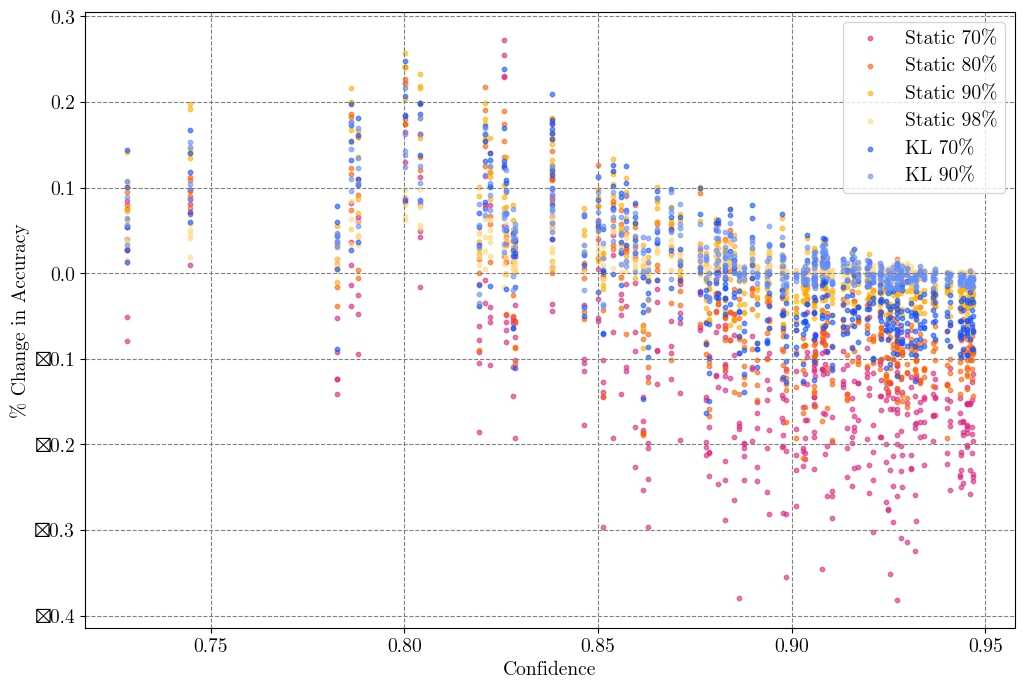

In [ ]:
# scatter plot with x-axis as
df = pd.DataFrame(columns=["Momentum", "Accuracy", "$\Delta$ Acc.", "Entropy", "$\Delta$ Ent.", "ECE", "$\Delta$ ECE"])
plt.figure(figsize=(12, 8))
labels = ["Static 70%", "Static 80%", "Static 90%", "Static 98%", "KL 70%", "KL 90%"]
colors = ["#DC267F", "#FE6100", "#FFB000", "#FFD983", "#1253FF", "#648FFF"]
for i, files in enumerate([res_stat70_files, res_stat80_files, res_stat90_files, res_stat98_files, res_kl70_files, res_kl90_files]):
  accs = []
  ents = []
  cals = []
  # confs = []
  # scatters = []
  for f in files:
    results = np.load(f, allow_pickle=True)[()]
    corruption_level = int(f.split("/")[3].split("_resnet18")[0][-1])
    smax = torch.softmax(torch.concatenate(results["out"]), dim=1)
    accs.append(results["acc"])
    ents.append(entropy(smax, axis=1))
    cals.append(calibration(torch.concatenate(results["labels"]), torch.nn.functional.softmax(torch.concatenate(results["out"]), dim=1)))

    # confs.append(torch.max(smax, axis=1)[0])
  plt.scatter([c.mean() for c in res_conf_8], (np.array(accs) - np.array(res_accs_8)), alpha=0.6, s=10, color=colors[i], label=labels[i])



  df.loc[i] = [
    labels[i],
    [get_pm_str(fix_trials(accs), j) for j in range(1, 6)],
    (np.mean(accs) - np.mean(res_accs_8)).round(4),
    [get_pm_str(fix_trials(ents), j) for j in range(1, 6)],
    (np.mean(ents) - np.mean(res_ent_8)).round(4),
    [get_pm_str(fix_trials(np.array([c["ece"] for c in res_cals_8])), j) for j in range(1, 6)],
    (np.mean([c["ece"] for c in cals]) - np.mean([c["ece"] for c in res_cals_8])).round(4)
  ]

plt.xticks(fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")

plt.xlabel("Confidence", fontproperties=fontprop)
plt.ylabel("% Change in Accuracy", fontproperties=fontprop)
plt.legend(prop=fontprop)
# plt.legend((scatters[0], scatters[1], scatters[2]), ("Level 1", "Level 3", "Level 5"), numpoints=1, prop=fontprop)
plt.show()

In [ ]:
np.random.randint(10)/1000

0.006

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


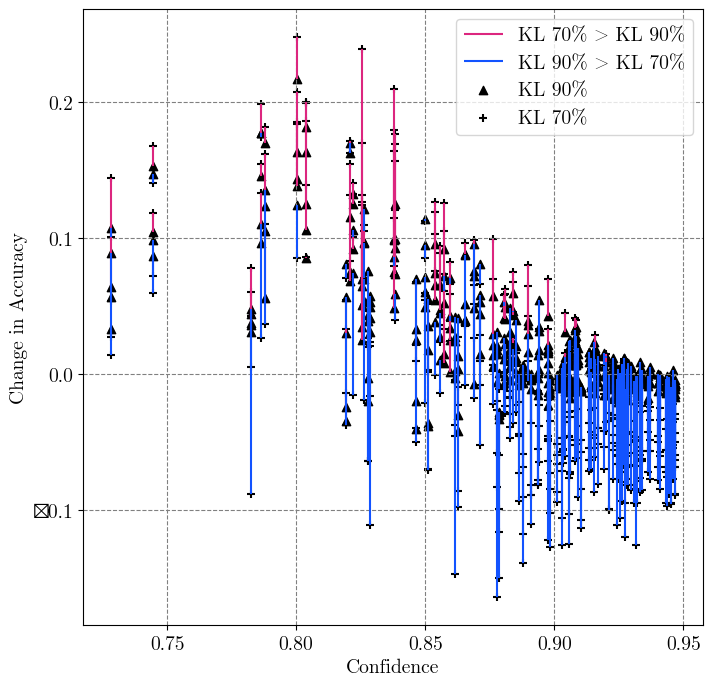

In [ ]:
# scatter plot with x-axis as
plt.figure(figsize=(8, 8))
labels = ["KL 70% > KL 90%", "KL 90% > KL 70%"]
colors = ["#DC267F", "#1253FF"]

# acc90 = []
# for f in res_kl90_files:
#   res = np.load(f, allow_pickle=True)[()]
#   acc90.append(res["acc"])

# accs = []
# for f in res_kl70_files:
#   results = np.load(f, allow_pickle=True)[()]
#   accs.append(results["acc"])

# pos_acc_min = []
# pos_acc_max = []
# pos_conf = []

# neg_acc_min = []
# neg_acc_max = []
# neg_conf = []

# for i, (kl70, kl90) in enumerate(zip(accs, acc90)):
#   if kl90 > kl70:
#     pos_acc_min.append(kl70-res_accs_8[i])
#     pos_acc_max.append(kl90-res_accs_8[i])
#     pos_conf.append(res_conf_8[i].mean())
#   else:
#     neg_acc_min.append(kl90-res_accs_8[i])
#     neg_acc_max.append(kl70-res_accs_8[i])
#     neg_conf.append(res_conf_8[i].mean())


plt.vlines(x=neg_conf, ymin=neg_acc_min, ymax=neg_acc_max, label=labels[0], colors=colors[0])
plt.vlines(x=pos_conf, ymin=pos_acc_min, ymax=pos_acc_max, label=labels[1], colors=colors[1])

plt.scatter([c.mean()+np.random.randint(10)/1000 for c in res_conf_8], np.array(acc90)-np.array(res_accs_8), marker="^", color="black", label="KL 90%")
plt.scatter([c.mean()+np.random.randint(10)/1000 for c in res_conf_8], np.array(accs)-np.array(res_accs_8), marker="+", color="black", label="KL 70%")

plt.xticks(fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")

plt.xlabel("Confidence", fontproperties=fontprop)
plt.ylabel("Change in Accuracy", fontproperties=fontprop)
plt.legend(prop=fontprop)
# plt.legend((scatters[0], scatters[1], scatters[2]), ("Level 1", "Level 3", "Level 5"), numpoints=1, prop=fontprop)
plt.show()

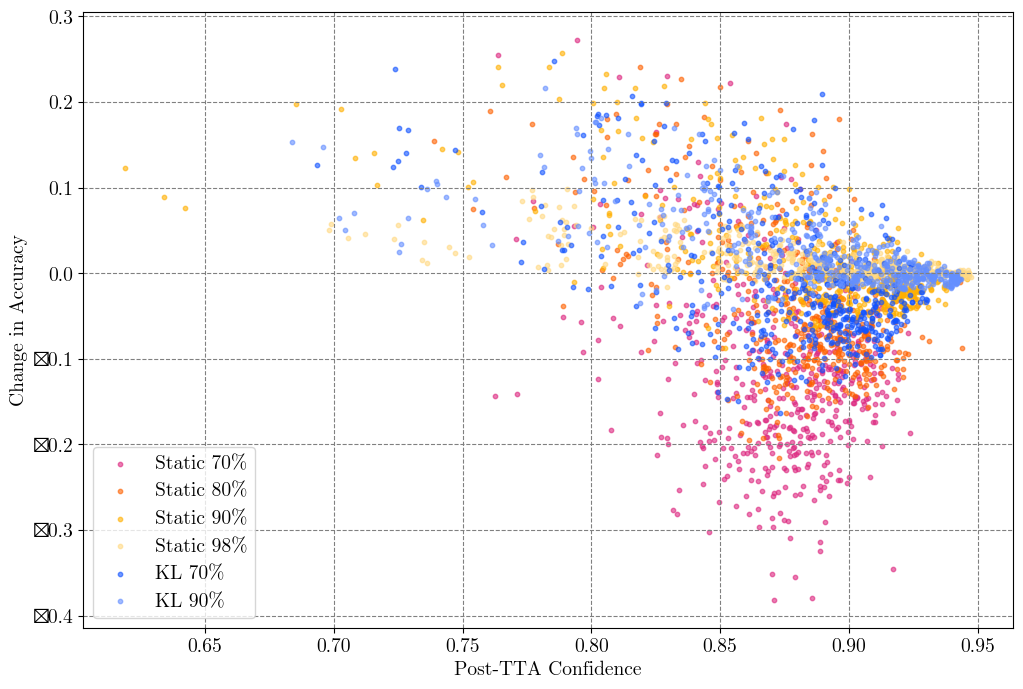

In [ ]:
# scatter plot with x-axis as
plt.figure(figsize=(12, 8))
labels = ["Static 70%", "Static 80%", "Static 90%", "Static 98%", "KL 70%", "KL 90%"]
colors = ["#DC267F", "#FE6100", "#FFB000", "#FFD983", "#1253FF", "#648FFF"]
df_count = 0
for i, files in enumerate([res_stat70_files, res_stat80_files, res_stat90_files, res_stat98_files, res_kl70_files, res_kl90_files]):
  accs = []
  ents = []
  cals = []
  confs = []
  # scatters = []
  for f in files:
    results = np.load(f, allow_pickle=True)[()]
    corruption_level = int(f.split("/")[3].split("_resnet18")[0][-1])
    smax = torch.softmax(torch.concatenate(results["out"]), dim=1)
    accs.append(results["acc"])
    ents.append(entropy(smax, axis=1))
    confs.append(torch.max(smax, axis=1)[0])
    cals.append(calibration(torch.concatenate(results["labels"]), torch.nn.functional.softmax(torch.concatenate(results["out"]), dim=1)))

    # confs.append(torch.max(smax, axis=1)[0])
  plt.scatter([c.mean() for c in confs], (np.array(accs) - np.array(res_accs_8)), alpha=0.6, s=10, color=colors[i], label=labels[i])


plt.xticks(fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")

plt.xlabel("Post-TTA Confidence", fontproperties=fontprop)
plt.ylabel("Change in Accuracy", fontproperties=fontprop)
plt.legend(prop=fontprop)
# plt.legend((scatters[0], scatters[1], scatters[2]), ("Level 1", "Level 3", "Level 5"), numpoints=1, prop=fontprop)
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


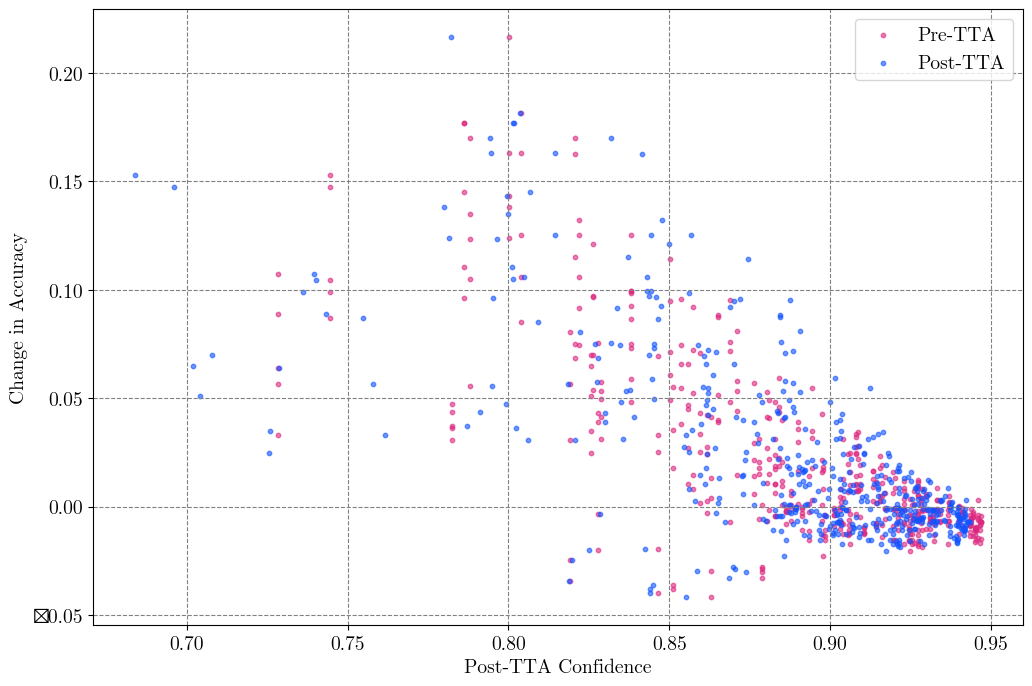

In [ ]:
# scatter plot with x-axis as
plt.figure(figsize=(12, 8))
labels = ["Static 70%", "Static 80%", "Static 90%", "Static 98%", "KL 70%", "KL 90%"]
colors = ["#DC267F", "#FE6100", "#FFB000", "#FFD983", "#1253FF", "#648FFF"]
df_count = 0
for i, files in enumerate([res_kl90_files]):
  accs = []
  ents = []
  cals = []
  confs = []
  # scatters = []
  for f in files:
    results = np.load(f, allow_pickle=True)[()]
    corruption_level = int(f.split("/")[3].split("_resnet18")[0][-1])
    smax = torch.softmax(torch.concatenate(results["out"]), dim=1)
    accs.append(results["acc"])
    ents.append(entropy(smax, axis=1))
    confs.append(torch.max(smax, axis=1)[0])
    cals.append(calibration(torch.concatenate(results["labels"]), torch.nn.functional.softmax(torch.concatenate(results["out"]), dim=1)))

    # confs.append(torch.max(smax, axis=1)[0])
  plt.scatter([c.mean() for c in res_conf_8], (np.array(accs) - np.array(res_accs_8)), alpha=0.6, s=10, color=colors[i], label="Pre-TTA")
  plt.scatter([c.mean() for c in confs], (np.array(accs) - np.array(res_accs_8)), alpha=0.6, s=10, color=colors[-2], label="Post-TTA")


plt.xticks(fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")

plt.xlabel("Post-TTA Confidence", fontproperties=fontprop)
plt.ylabel("Change in Accuracy", fontproperties=fontprop)
plt.legend(prop=fontprop)
# plt.legend((scatters[0], scatters[1], scatters[2]), ("Level 1", "Level 3", "Level 5"), numpoints=1, prop=fontprop)
plt.show()

In [ ]:
# how does confidence change?
conf_kl90 = []
for f in res_kl90_files:
  res = np.load(f, allow_pickle=True)[()]
  smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
  conf_kl90.append(torch.max(smax, axis=1)[0])
# res_conf_8

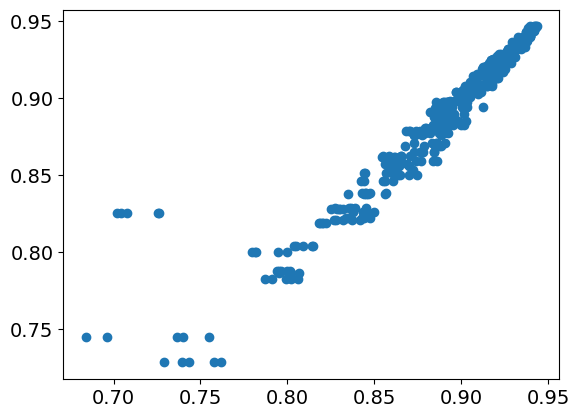

In [ ]:
plt.scatter([c.mean() for c in conf_kl90], [c.mean() for c in res_conf_8])

In [ ]:
# scatter plot with x-axis as
# df = pd.DataFrame(columns=["Momentum", "Accuracy", "$\Delta$ Acc.", "Entropy", "$\Delta$ Ent.", "ECE", "$\Delta$ ECE"])
df = pd.DataFrame(columns=["Momentum", "Accuracy", "Entropy", "ECE"])
plt.figure(figsize=(12, 8))
labels = ["Static 70%", "Static 80%", "Static 90%", "Static 98%", "KL 70%", "KL 90%"]
colors = ["#DC267F", "#FE6100", "#FFB000", "#FFD983", "#67771B", "#ADBD1B"]
df_count = 0
for i, files in enumerate([res_stat70_files, res_stat80_files, res_stat90_files, res_stat98_files, res_kl70_files, res_kl90_files]):
  accs = []
  ents = []
  cals = []
  confs = []
  # scatters = []
  for f in files:
    results = np.load(f, allow_pickle=True)[()]
    corruption_level = int(f.split("/")[3].split("_resnet18")[0][-1])
    smax = torch.softmax(torch.concatenate(results["out"]), dim=1)
    accs.append(results["acc"])
    ents.append(entropy(smax, axis=1))
    confs.append(torch.max(smax, axis=1)[0])
    cals.append(calibration(torch.concatenate(results["labels"]), torch.nn.functional.softmax(torch.concatenate(results["out"]), dim=1)))

    # confs.append(torch.max(smax, axis=1)[0])


  acc_str = [get_pm(fix_trials(accs), j) for j in range(1, 6)]
  ent_str = [get_pm(fix_trials(ents), j) for j in range(1, 6)]
  cal_str = [get_pm(fix_trials(np.array([c["ece"] for c in cals])), j) for j in range(1, 6)]
  # df.loc[df_count] = [
  #     labels[i],
  #     f"{np.mean([a[0] for a in acc_str]).round(4)} $\pm$ {np.sqrt(np.sum([a[1]**2 for a in acc_str])).round(4)}",
  #     f"{np.mean([a[0] for a in ent_str]).round(4)} $\pm$ {np.sqrt(np.sum([a[1]**2 for a in ent_str])).round(4)}",
  #     f"{np.mean([a[0] for a in cal_str]).round(4)} $\pm$ {np.sqrt(np.sum([a[1]**2 for a in cal_str]).round(4))}"
  # ]
  df.loc[df_count] = [
      labels[i],
      f"{np.mean(accs).round(4)} $\pm$ {np.std(accs).round(4)}",
      f"{np.mean(ents).round(4)} $\pm$ {np.std(ents).round(4)}",
      f"{np.mean([c['ece'] for c in cals]).round(4)} $\pm$ {np.std([c['ece'] for c in cals])}"
  ]
  df_count += 1

  # for k in range(5):
  #   a = acc_str[k]
  #   e = ent_str[k]
  #   c = cal_str[k]
  #   print(df_count)
  #   df.loc[df_count] = [
  #     labels[i],
  #     df_count % 5,
  #     a,
  #     # (np.mean(accs) - np.mean(res_accs_8)).round(4),
  #     e,
  #     # (np.mean(ents) - np.mean(res_ent_8)).round(4),
  #     c,
  #     # (np.mean([c["ece"] for c in cals]) - np.mean([c["ece"] for c in res_cals_8])).round(4)
  #   ]
  #   df_count += 1

# acc_str = [get_pm_str(fix_trials(res_accs_8), j) for j in range(1, 6)]
# ent_str = [get_pm_str(fix_trials(res_ent_8), j) for j in range(1, 6)]
# cal_str = [get_pm_str(fix_trials(np.array([c["ece"] for c in res_cals_8])), j) for j in range(1, 6)]

# for a, e, c in zip(acc_str, ent_str, cal_str):
#     df.loc[df_count] = [
#       "TTA-free",
#       df_count % 5,
#       a,
#       e,
#       c,
#     ]
#     df_count += 1
df.head(10)

,Momentum,Accuracy,Entropy,ECE
0,Static 70%,0.643 $\pm$ 0.1127,0.4004000127315521 $\pm$ 0.48399999737739563,0.2311 $\pm$ 0.09248583159910671
1,Static 80%,0.7256 $\pm$ 0.1092,0.397599995136261 $\pm$ 0.521399974822998,0.1634 $\pm$ 0.07814246578157168
2,Static 90%,0.7822 $\pm$ 0.1153,0.40400001406669617 $\pm$ 0.5005000233650208,0.1066 $\pm$ 0.07006491491921472
3,Static 98%,0.779 $\pm$ 0.1468,0.4018000066280365 $\pm$ 0.4578999876976013,0.1109 $\pm$ 0.09988771009812082
4,KL 70%,0.7562 $\pm$ 0.1146,0.43700000643730164 $\pm$ 0.4943999946117401,0.1212 $\pm$ 0.07903020872894113
5,KL 90%,0.7881 $\pm$ 0.1297,0.4009000062942505 $\pm$ 0.45899999141693115,0.1019 $\pm$ 0.08311148626510088


<Figure size 1200x800 with 0 Axes>

In [ ]:
df.to_latex(index=False)

'\\begin{tabular}{llll}\n\\toprule\nMomentum & Accuracy & Entropy & ECE \\\\\n\\midrule\nStatic 70% & 0.643 $\\pm$ 0.1127 & 0.4004000127315521 $\\pm$ 0.48399999737739563 & 0.2311 $\\pm$ 0.09248583159910671 \\\\\nStatic 80% & 0.7256 $\\pm$ 0.1092 & 0.397599995136261 $\\pm$ 0.521399974822998 & 0.1634 $\\pm$ 0.07814246578157168 \\\\\nStatic 90% & 0.7822 $\\pm$ 0.1153 & 0.40400001406669617 $\\pm$ 0.5005000233650208 & 0.1066 $\\pm$ 0.07006491491921472 \\\\\nStatic 98% & 0.779 $\\pm$ 0.1468 & 0.4018000066280365 $\\pm$ 0.4578999876976013 & 0.1109 $\\pm$ 0.09988771009812082 \\\\\nKL 70% & 0.7562 $\\pm$ 0.1146 & 0.43700000643730164 $\\pm$ 0.4943999946117401 & 0.1212 $\\pm$ 0.07903020872894113 \\\\\nKL 90% & 0.7881 $\\pm$ 0.1297 & 0.4009000062942505 $\\pm$ 0.45899999141693115 & 0.1019 $\\pm$ 0.08311148626510088 \\\\\n\\bottomrule\n\\end{tabular}\n'

In [ ]:
class_freqs = {}
plt.figure(figsize=(16, 4))
labels = ["Static 70%", "Static 80%", "KL 70%", "Static 98%", "KL 90%"]
colors = ["#CC76A0", "#D0478A", "#9785EC", "#DC267F", "#785EF0"]
for i, files in enumerate([moment70_files, moment80_files, kl70_files, moment98_files, kl90_files]):
  ents = []
  accs = []
  ents_std = []
  cals = []
  class_freq = [0]*10

  for f in files:
    results = np.load(f, allow_pickle=True)[()]
    # corruption_level = int(f.split("/")[3].split("_resnet18")[0][-1])
    smax = torch.softmax(torch.concatenate(results["out"]), dim=1)
    accs.append(results["acc"])
    cals.append(calibration(torch.concatenate(results["labels"]), torch.nn.functional.softmax(torch.concatenate(results["out"]), dim=1)))
    ents.append(entropy(smax, axis=1))
    ents_std.append(ents[-1].std())
    for s in smax:
      class_freq[s.argmax()] += 1

  # plt.bar([j+0.3*i for j in range(0, 2*len(xlabels), 2)], np.array(accs) - np.array(accs_8), label=labels[i], width=0.3, color=colors[i])
  class_freqs[i] = class_freq


  df.loc[i] = ["", np.mean(accs), np.mean(accs) - np.mean(accs_8), f"{np.mean(ents)} $\pm$ {np.std(ents)}", np.mean(ents) - np.mean(ents_8), np.mean([c["ece"] for c in cals]), np.mean([c["ece"] for c in cals]) - np.mean([c["ece"] for c in cals_8])]

# plt.legend(prop=fontprop, loc="lower right")
# plt.xticks(ticks=range(0, 2*len(xlabels), 6), minor=False, labels=[m.replace("_", " ") for m in major_labels],  fontproperties=fontprop, rotation=90)
# plt.xticks(ticks=range(0, 2*len(xlabels), 2), labels=xlabels, minor=True, fontproperties=fontprop)
# plt.yticks(fontproperties=fontprop)
# plt.grid(color='gray', linestyle='dashed', which="major")

# plt.xlabel("Corruption Category", fontproperties=fontprop)
# plt.ylabel("Change in Accuracy", fontproperties=fontprop)

<Figure size 1600x400 with 0 Axes>

In [ ]:
df.head(10)

,Adaptation,Accuracy,$\Delta$Acc,Entropy,$\Delta$Ent,ECE,$\Delta$ECE
0,,0.646974,-0.118325,0.39374876022338867 $\pm$ 0.48425525426864624,-0.005276,0.230038,0.104782
1,,0.716776,-0.048522,0.3985114097595215 $\pm$ 0.5252338647842407,-0.000514,0.170446,0.045190
2,,0.739224,-0.026075,0.4730623960494995 $\pm$ 0.521352231502533,0.074037,0.125277,0.000022
3,,0.777061,0.011763,0.4016462564468384 $\pm$ 0.45727959275245667,0.002621,0.113100,-0.012155
4,,0.787737,0.022439,0.4003954231739044 $\pm$ 0.4645063877105713,0.001370,0.102448,-0.022808


In [ ]:
[accs[-1]-np.mean(accs_8)]

[0.021201754385965055]

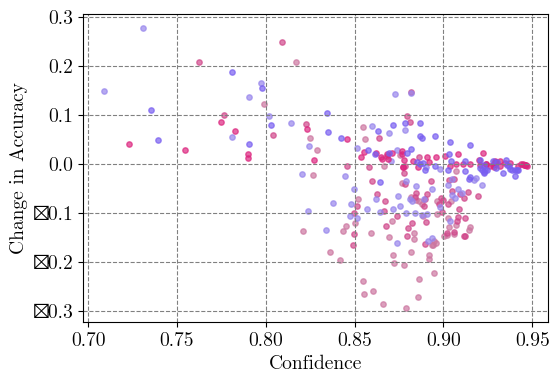

In [ ]:
# class_freqs = {}
plt.figure(figsize=(6, 4))
labels = ["Static 70%", "Static 80%", "KL 70%", "Static 98%", "KL 90%"]
colors = ["#CC76A0", "#D0478A", "#9785EC", "#DC267F", "#785EF0"]
for i, files in enumerate([moment70_files, moment80_files, kl70_files, moment98_files, kl90_files]):
  # ents = []
  accs = []
  # ents_std = []
  confs = []
  # confs_std = []
  # cals = []
  scatters = []
  for f in files:
    results = np.load(f, allow_pickle=True)[()]
    corruption_level = int(f.split("/")[3].split("_resnet18")[0][-1])
    smax = torch.softmax(torch.concatenate(results["out"]), dim=1)
    accs.append(results["acc"])
    # cals.append(calibration(torch.concatenate(results["labels"]), torch.nn.functional.softmax(torch.concatenate(results["out"]), dim=1)))
    # ents.append(entropy(smax, axis=1))
    # ents_std.append(ents[-1].std())
    confs.append(torch.max(smax, axis=1)[0])
    # confs_std.append(confs[-1].std())

    # s = plt.scatter([torch.mean(confs[-1])], [accs[-1]-np.mean(accs_8)], alpha=0.5, s=2**corruption_level, color=colors[i])
    # scatters.append(s)
  plt.scatter([c.mean() for c in confs], np.array(accs) - np.array(accs_8), alpha=0.7, s=15, color=colors[i])

plt.xticks(fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.grid(color='gray', linestyle='dashed', which="major")

plt.xlabel("Confidence", fontproperties=fontprop)
plt.ylabel("Change in Accuracy", fontproperties=fontprop)
# plt.legend((scatters[0], scatters[1], scatters[2]), ("Level 1", "Level 3", "Level 5"), numpoints=1, prop=fontprop)
plt.show()

Text(0, 0.5, 'Percentage of Predictions')

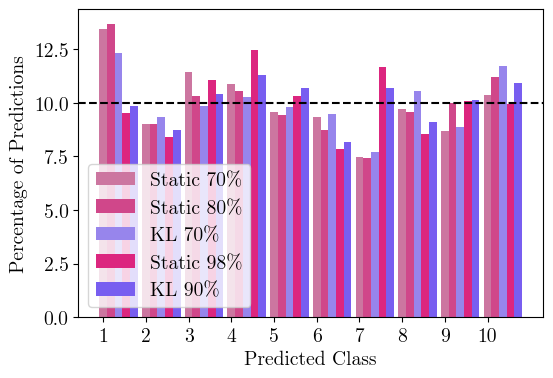

In [ ]:
plt.figure(figsize=(6, 4))
labels = ["Static 70%", "Static 80%", "KL 70%", "Static 98%", "KL 90%"]
colors = ["#CC76A0", "#D0478A", "#9785EC", "#DC267F", "#785EF0"]
for mt in class_freqs:
  plt.bar([i+0.18*mt+1 for i in range(10)], (class_freqs[mt]/np.sum(class_freqs[mt]))*100, width=0.18, label=labels[mt], color=colors[mt])
plt.legend(prop=fontprop, loc="lower left")
plt.axhline(10, color="black", linestyle="--")
plt.xticks(range(1, 11), fontproperties=fontprop)
plt.yticks(fontproperties=fontprop)
plt.xlabel("Predicted Class", fontproperties=fontprop)
plt.ylabel("Percentage of Predictions", fontproperties=fontprop)


In [ ]:
df.style.format(precision=4)
df.to_latex()

'\\begin{tabular}{llrrlrrr}\n\\toprule\n & Adaptation & Accuracy & $\\Delta$Acc & Entropy & $\\Delta$Ent & ECE & $\\Delta$ECE \\\\\n\\midrule\n0 &  & 0.646974 & -0.118325 & 0.39374876022338867 $\\pm$ 0.39374876022338867 & -0.005276 & 0.230038 & 0.104782 \\\\\n1 &  & 0.716776 & -0.048522 & 0.3985114097595215 $\\pm$ 0.3985114097595215 & -0.000514 & 0.170446 & 0.045190 \\\\\n2 &  & 0.739224 & -0.026075 & 0.4730623960494995 $\\pm$ 0.4730623960494995 & 0.074037 & 0.125277 & 0.000022 \\\\\n3 &  & 0.777061 & 0.011763 & 0.4016462564468384 $\\pm$ 0.4016462564468384 & 0.002621 & 0.113100 & -0.012155 \\\\\n4 &  & 0.787737 & 0.022439 & 0.4003954231739044 $\\pm$ 0.4003954231739044 & 0.001370 & 0.102448 & -0.022808 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Looking at KL-divergence

/content/trials/impulse_noise_1_mbnet_int8_c10kl90_b1_0.npy
/content/trials/impulse_noise_1_mbnet_int8_c10kl90_b1_1.npy
/content/trials/impulse_noise_1_mbnet_int8_c10kl90_b1_2.npy
/content/trials/impulse_noise_1_mbnet_int8_c10kl90_b1_3.npy
/content/trials/impulse_noise_1_mbnet_int8_c10kl90_b1_4.npy
/content/trials/impulse_noise_2_mbnet_int8_c10kl90_b1_0.npy
/content/trials/impulse_noise_2_mbnet_int8_c10kl90_b1_1.npy
/content/trials/impulse_noise_2_mbnet_int8_c10kl90_b1_2.npy
/content/trials/impulse_noise_2_mbnet_int8_c10kl90_b1_3.npy
/content/trials/impulse_noise_2_mbnet_int8_c10kl90_b1_4.npy
/content/trials/impulse_noise_3_mbnet_int8_c10kl90_b1_0.npy
/content/trials/impulse_noise_3_mbnet_int8_c10kl90_b1_1.npy
/content/trials/impulse_noise_3_mbnet_int8_c10kl90_b1_2.npy
/content/trials/impulse_noise_3_mbnet_int8_c10kl90_b1_3.npy
/content/trials/impulse_noise_3_mbnet_int8_c10kl90_b1_4.npy
/content/trials/impulse_noise_4_mbnet_int8_c10kl90_b1_0.npy
/content/trials/impulse_noise_4_mbnet_in

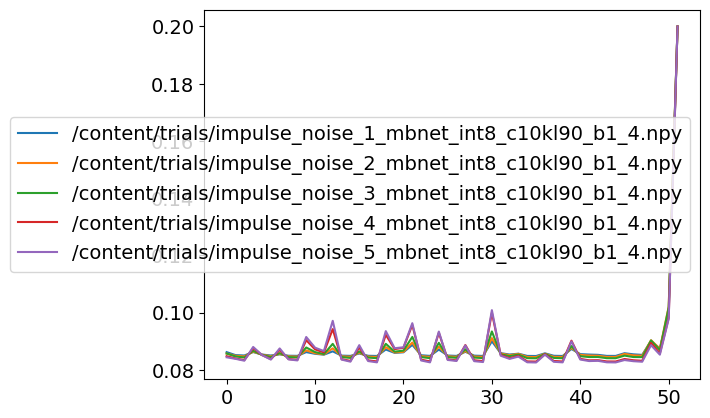

In [ ]:
import math
def scale_to_mean_std(numbers):
    mean = np.mean(numbers)
    std = math.sqrt(sum((x - mean) ** 2 for x in numbers) / len(numbers))
    scaled_numbers = [(x - mean) / std for x in numbers]
    return scaled_numbers


for flg in [mbn_kl90_files[225:250]]:
  for i in range(0, len(flg), 5):
    kl_avg = []
    for j in range(5):
      print(flg[i+j])
      res = np.load(flg[i+j], allow_pickle=True)[()]
      if "kl" in res:
        kl = res["kl"]
      else:
        kl = res["kl_divs"]

      kl_divs_normed = np.array([(max(min(div, 1), -1) +1)/2 for div in scale_to_mean_std(kl)])
      kl_avg.append(kl_divs_normed)
    plt.plot(np.mean(np.array(kl_avg), axis=0) / 5., label=flg[i+j])
plt.legend()



# Section 4.5 Quantization

In [ ]:
!curl -X POST https://content.dropboxapi.com/2/files/download \
    --header "Authorization: Bearer <>" \
    --header "Dropbox-API-Arg: {\"path\":\"/cifar100/res_fp32_c100base.zip\"}" \
    --output /content/baseline/res_fp32_c100base.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    94  100    94    0     0     94      0  0:00:01 --:--:--  0:00:01    94


In [ ]:
!ls /content/baseline/ | grep .zip


mbnet_fp32_base.zip
mbnet_int8_base.zip
res_fp32_base.zip
res_fp32_c100base.zip
res_int8_base.zip
res_int8_c100base.zip


In [ ]:
!unzip /content/baseline/res_fp32_base.zip
!unzip /content/kl/res_fp32_c10kl90_b1.zip
!mv *.npy trials
# !unzip /content/baseline/res_fp32_c100base.zip
# !mv *.npy trials100
# clear_output()

In [ ]:
res_base_fp32_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*fp32_base*.npy"))))
res_kl90_fp32_files = list(filter(lambda x: "none" not in x, sorted(glob.glob("/content/trials/*fp32_c10kl90_b1*.npy"))))

In [ ]:
confs_8 = []
accs_8 = []
ents_8 = []
cals_8 = []

confs_32 = []
accs_32 = []
ents_32 = []
cals_32 = []

for f8, f32 in zip(res_kl90_files, res_kl90_fp32_files):
  res = np.load(f8, allow_pickle=True)[()]
  accs_8.append(res["acc"])
  smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
  ents_8.append(np.mean(entropy(smax, axis=1))/np.log(10))
  confs_8.append(torch.max(smax, axis=1)[0].mean())
  cals_8.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1))["ece"])

  res = np.load(f32, allow_pickle=True)[()]
  accs_32.append(res["acc"])
  smax = torch.softmax(torch.concatenate(res["out"]), dim=1)
  ents_32.append(np.mean(entropy(smax, axis=1))/np.log(10))
  confs_32.append(torch.max(smax, axis=1)[0].mean())
  cals_32.append(calibration(torch.concatenate(res["labels"]), torch.nn.functional.softmax(torch.concatenate(res["out"]), dim=1))["ece"])

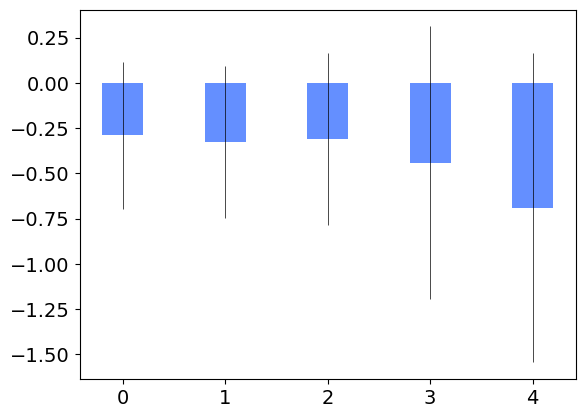

In [ ]:
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]

for sev_num in range(5):
  take_arr = []
  for corr_num in range(0, len(accs_8), 25):
    for i in range(5):
      take_arr.append(corr_num+i+5*sev_num)

  temp_8 = np.array(accs_8)[take_arr]
  temp_32 = np.array(accs_32)[take_arr]
  plt.bar([sev_num], 100*np.mean((temp_8 - temp_32)/temp_32), width=0.4, color=colors[0], label="Quantized")
  plt.errorbar([sev_num], 100*np.mean((temp_8 - temp_32)/temp_32), yerr=np.std(100*(temp_8 - temp_32)/temp_32), color="black", elinewidth=0.5)
  # plt.bar([i+j*0.4 for j in range(5)], width=0.4, color=colors[0], label="Full-Precision")

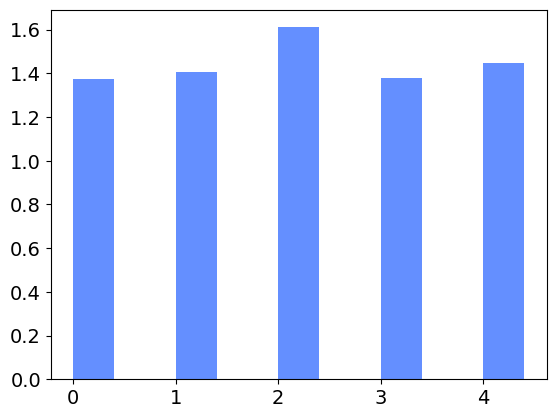

In [ ]:
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]

for sev_num in range(5):
  take_arr = []
  for corr_num in range(0, len(ents_8), 25):
    for i in range(5):
      take_arr.append(corr_num+i+5*sev_num)

  temp_8 = np.array(ents_8)[take_arr]
  temp_32 = np.array(ents_32)[take_arr]
  plt.bar([sev_num], 100*np.mean((temp_8 - temp_32)/temp_32), width=0.4, color=colors[0], label="Quantized", align="edge")
  plt.errorbar([sev_num], np.mean((temp_8 - temp_32)/temp_32), color="black", elinewidth=0.5)
  # plt.bar([i+j*0.4 for j in range(5)], width=0.4, color=colors[0], label="Full-Precision")

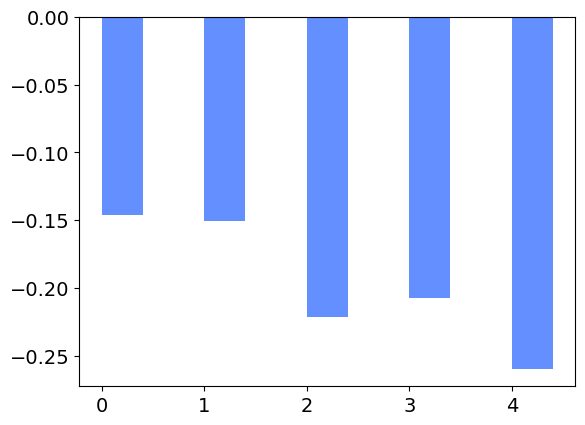

In [ ]:
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]

for sev_num in range(5):
  take_arr = []
  for corr_num in range(0, len(confs_8), 25):
    for i in range(5):
      take_arr.append(corr_num+i+5*sev_num)

  temp_8 = np.array(confs_8)[take_arr]
  temp_32 = np.array(confs_32)[take_arr]
  plt.bar([sev_num], 100*np.mean((temp_8 - temp_32)/temp_32), width=0.4, color=colors[0], label="Quantized", align="edge")
  plt.errorbar([sev_num], np.mean((temp_8 - temp_32)/temp_32), color="black", elinewidth=0.5)
  # plt.bar([i+j*0.4 for j in range(5)], width=0.4, color=colors[0], label="Full-Precision")

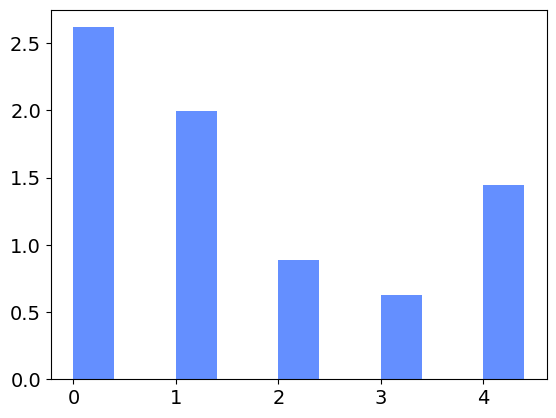

In [ ]:
colors = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000"]

for sev_num in range(5):
  take_arr = []
  for corr_num in range(0, len(cals_8), 25):
    for i in range(5):
      take_arr.append(corr_num+i+5*sev_num)

  temp_8 = np.array(cals_8)[take_arr]
  temp_32 = np.array(cals_32)[take_arr]
  plt.bar([sev_num], 100*np.mean((temp_8 - temp_32)/temp_32), width=0.4, color=colors[0], label="Quantized", align="edge")
  plt.errorbar([sev_num], np.mean((temp_8 - temp_32)/temp_32), color="black", elinewidth=0.5)
  # plt.bar([i+j*0.4 for j in range(5)], width=0.4, color=colors[0], label="Full-Precision")

# Miscellaneous rejected figures

In [ ]:
!curl -X POST https://content.dropboxapi.com/2/files/download \
    --header "Authorization: Bearer <>" \
    --header "Dropbox-API-Arg: {\"path\":\"/mem.npy\"}" \
    --output /content/sharp_1_mems.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4441k  100 4441k    0     0  5324k      0 --:--:-- --:--:-- --:--:-- 5331k


In [ ]:
memory_trace = np.load("/content/sharp_1_mems.npy", allow_pickle=True)[()]
times = memory_trace["st"]
mem_list = memory_trace["mem"]

0 0.011959075927734375
1 0.00048065185546875
2 0.016815185546875
3 0.007160186767578125
4 0.0011444091796875


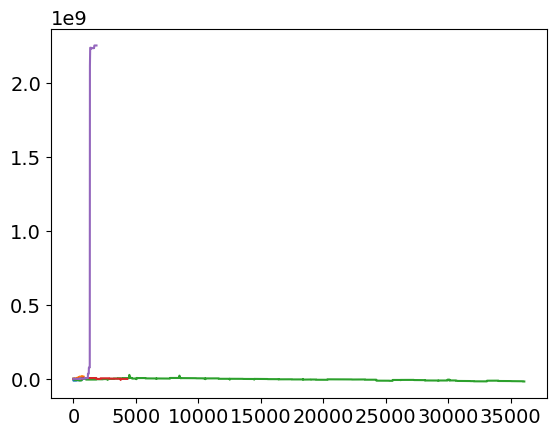

In [ ]:
i = 0
for (start_time, end_time) in [(1717161434.5544114, 1717161438.8400893), (1717161438.8400893, 1717161443.096791), (1717161443.096791, 1717161628.1994498), (1717161628.1994498, 1717161650.3657763), (1717161650.3657763, 1717161660)]:
  memory_usage = []
  mstart = 0
  for t, m in zip(times, mem_list):
    if t > start_time and t < end_time:
      memory_usage.append(m.available-mstart)
    else:
        mstart = m.available
  print(i, -1*min(memory_usage)/(1024**3))
  plt.plot(memory_usage)
  i += 1

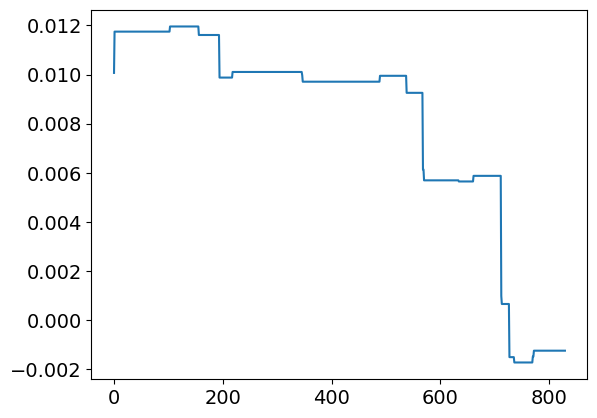